# Prediksi Kemacetan Kota Essen

Notebook ini berisi langkah-langkah untuk memprediksi status lalu lintas di Kota Essen berdasarkan data historis. Proyek ini mencakup:
1.  **Data Loading & Cleaning**: Memuat dataset dan membersihkan data.
2.  **Exploratory Data Analysis (EDA)**: Menganalisis pola lalu lintas (Stacked Plots & Heatmap).
3.  **Feature Engineering**: Membuat fitur tanggal dan waktu.
4.  **Modeling**: Melatih model Random Forest dan Gradient Boosting.
5.  **Prediction Interface**: Fungsi untuk memprediksi lalu lintas berdasarkan input pengguna.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.metrics import classification_report, confusion_matrix, mean_squared_error
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

## 1. Data Loading & Cleaning

In [2]:
# Menampilkan dataset
df = pd.read_csv('essen.csv')
print("Dataset loaded successfully.")
display(df.head())

Dataset loaded successfully.


,day,interval,detid,flow,occ,error,city,speed
0,2017-03-27,36000,esss102n,214.75,0.00625,1.0,essen,25.662790
1,2017-03-27,36300,esss102n,455.00,0.01500,0.0,essen,52.758244
2,2017-03-27,36600,esss102n,410.00,0.01500,0.0,essen,52.219513
3,2017-03-27,36900,esss102n,415.00,0.01500,0.0,essen,50.120483
4,2017-03-27,37200,esss102n,380.00,0.01500,0.0,essen,50.684210


In [3]:
# Check info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 291893 entries, 0 to 291892
Data columns (total 8 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   day       291893 non-null  object 
 1   interval  291893 non-null  int64  
 2   detid     291893 non-null  object 
 3   flow      291893 non-null  float64
 4   occ       291548 non-null  float64
 5   error     291893 non-null  float64
 6   city      291893 non-null  object 
 7   speed     291892 non-null  float64
dtypes: float64(4), int64(1), object(3)
memory usage: 17.8+ MB


In [4]:
# Filter out error rows
if 'error' in df.columns:
    print("Error distribution:")
    print(df['error'].value_counts())
    df = df[df['error'] == 0.0]
    df.drop(columns=['error'], inplace=True)
    print("Error rows removed.")

Error distribution:
error
0.0    291065
1.0       828
Name: count, dtype: int64
Error rows removed.


In [5]:
# Convert 'day' to datetime
df['day'] = pd.to_datetime(df['day'])

### Aggregation
Mengagregasi data berdasarkan waktu (`day` dan `interval`) untuk mendapatkan rata-rata status kota.

In [6]:
df_agg = df.groupby(['day', 'interval'])[['flow', 'occ', 'speed']].mean().reset_index()
df_agg.head()

,day,interval,flow,occ,speed
0,2017-03-27,36300,333.287037,0.027315,49.788482
1,2017-03-27,36600,314.444444,0.027014,49.895314
2,2017-03-27,36900,329.907407,0.025949,50.487936
3,2017-03-27,37200,337.777778,0.021713,50.977720
4,2017-03-27,37800,338.611111,0.027431,50.072745


## 2. Feature Engineering

In [7]:
# Extract Time Features
df_agg['year'] = df_agg['day'].dt.year
df_agg['month'] = df_agg['day'].dt.month
df_agg['day_of_month'] = df_agg['day'].dt.day
df_agg['day_of_week'] = df_agg['day'].dt.dayofweek

# Interval conversion (seconds to hour/minute)
df_agg['hour'] = (df_agg['interval'] // 3600).astype(int)
df_agg['minute'] = ((df_agg['interval'] % 3600) // 60).astype(int)

# Define Traffic Status
def get_status(speed):
    if speed <= 40:
        return 'Macet'
    elif speed <= 50:
        return 'Padat'
    else:
        return 'Lancar'

df_agg['status'] = df_agg['speed'].apply(get_status)
df_agg.head()

,day,interval,flow,occ,speed,year,month,day_of_month,day_of_week,hour,minute,status
0,2017-03-27,36300,333.287037,0.027315,49.788482,2017,3,27,0,10,5,Padat
1,2017-03-27,36600,314.444444,0.027014,49.895314,2017,3,27,0,10,10,Padat
2,2017-03-27,36900,329.907407,0.025949,50.487936,2017,3,27,0,10,15,Lancar
3,2017-03-27,37200,337.777778,0.021713,50.977720,2017,3,27,0,10,20,Lancar
4,2017-03-27,37800,338.611111,0.027431,50.072745,2017,3,27,0,10,30,Lancar


## 3. Exploratory Data Analysis (EDA)

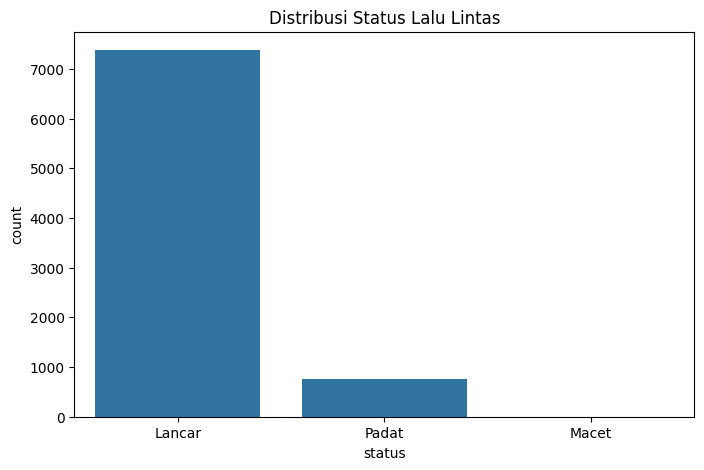

In [8]:
# Visualization: Stacked Plots for Speed, Flow, Occupancy
df_viz = df_agg.copy()
df_viz['day_type'] = df_viz['day_of_week'].apply(lambda x: 'Weekend' if x >= 5 else 'Weekday')

plot_data = df_viz.groupby(['hour', 'day_type'])[['speed', 'flow', 'occ']].mean().reset_index()
all_days = df_viz.groupby('hour')[['speed', 'flow', 'occ']].mean().reset_index()
all_days['day_type'] = 'All Days'
plot_data = pd.concat([plot_data, all_days])

# Speed Plot
plt.figure(figsize=(10, 5))
sns.lineplot(x='hour', y='speed', hue='day_type', data=plot_data, style='day_type', markers=True)
plt.title('Rata-rata Kecepatan per Jam')
plt.xticks(range(24))
plt.grid(True)
plt.show()

# Flow Plot
plt.figure(figsize=(10, 5))
sns.lineplot(x='hour', y='flow', hue='day_type', data=plot_data, style='day_type', markers=True)
plt.title('Rata-rata Flow per Jam')
plt.xticks(range(24))
plt.grid(True)
plt.show()

# Occupancy Plot
plt.figure(figsize=(10, 5))
sns.lineplot(x='hour', y='occ', hue='day_type', data=plot_data, style='day_type', markers=True)
plt.title('Rata-rata Occupancy per Jam')
plt.xticks(range(24))
plt.grid(True)
plt.show()

# Correlation Heatmap
plt.figure(figsize=(8, 6))
corr_cols = ['speed', 'flow', 'occ', 'hour', 'day_of_week', 'month']
sns.heatmap(df_agg[corr_cols].corr(), annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
plt.title('Correlation Heatmap')
plt.show()

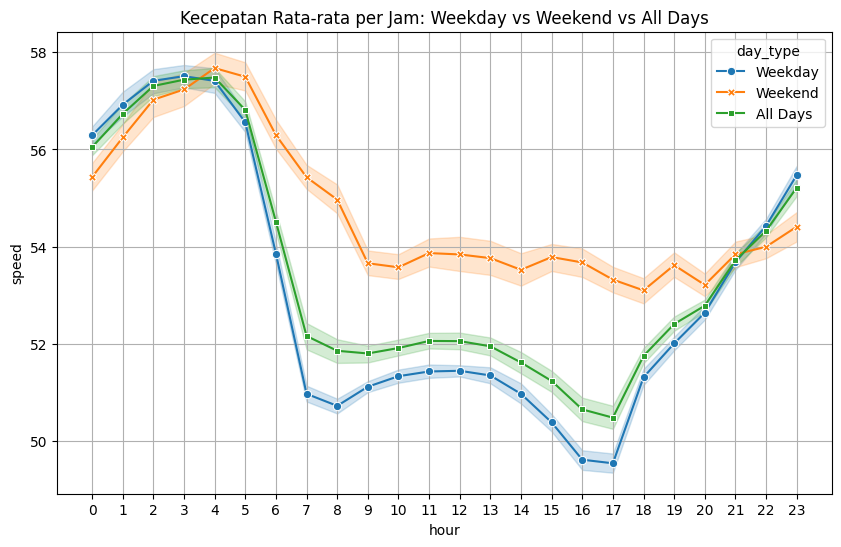

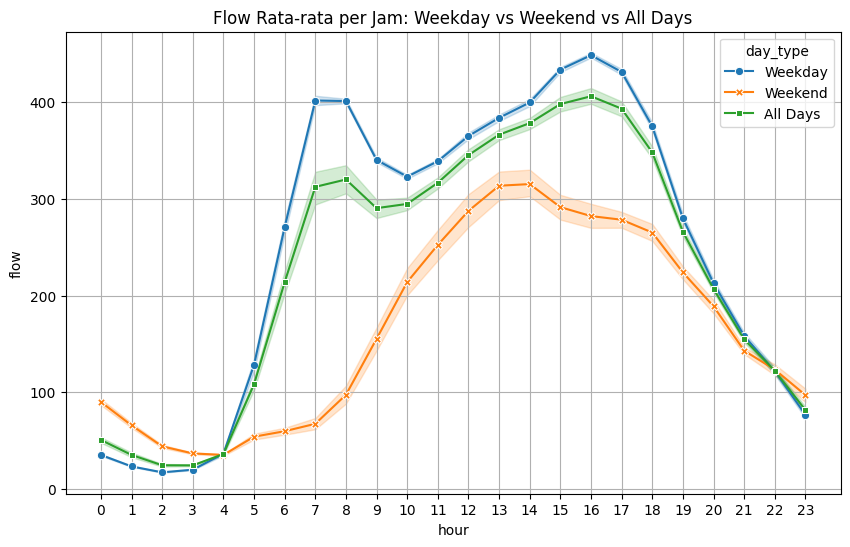

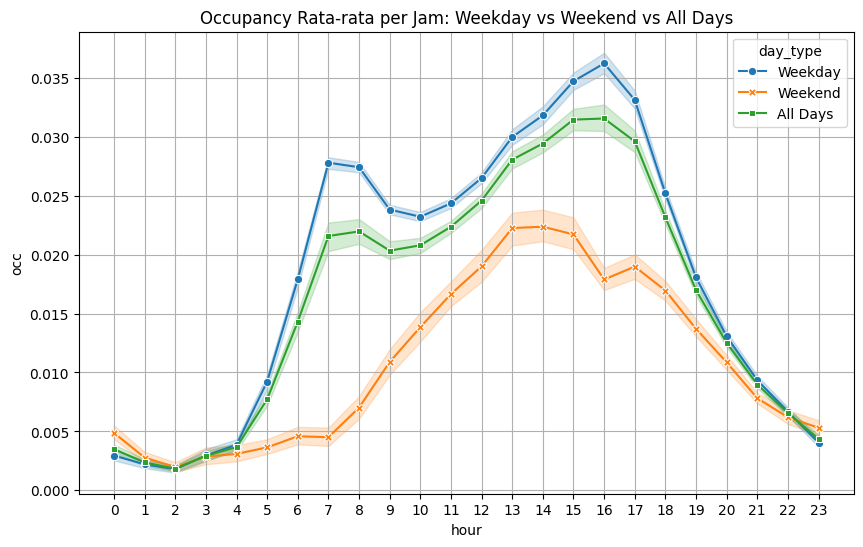

In [9]:
# Visualization: Stacked Plots for Speed, Flow, Occupancy
df_viz = df_agg.copy()
df_viz['day_type'] = df_viz['day_of_week'].apply(lambda x: 'Weekend' if x >= 5 else 'Weekday')

plot_data = df_viz.groupby(['hour', 'day_type'])[['speed', 'flow', 'occ']].mean().reset_index()
all_days = df_viz.groupby('hour')[['speed', 'flow', 'occ']].mean().reset_index()
all_days['day_type'] = 'All Days'
plot_data = pd.concat([plot_data, all_days])

# Speed Plot
plt.figure(figsize=(10, 5))
sns.lineplot(x='hour', y='speed', hue='day_type', data=plot_data, style='day_type', markers=True)
plt.title('Rata-rata Kecepatan per Jam')
plt.xticks(range(24))
plt.grid(True)
plt.show()

# Flow Plot
plt.figure(figsize=(10, 5))
sns.lineplot(x='hour', y='flow', hue='day_type', data=plot_data, style='day_type', markers=True)
plt.title('Rata-rata Flow per Jam')
plt.xticks(range(24))
plt.grid(True)
plt.show()

# Occupancy Plot
plt.figure(figsize=(10, 5))
sns.lineplot(x='hour', y='occ', hue='day_type', data=plot_data, style='day_type', markers=True)
plt.title('Rata-rata Occupancy per Jam')
plt.xticks(range(24))
plt.grid(True)
plt.show()

# Correlation Heatmap
plt.figure(figsize=(8, 6))
corr_cols = ['speed', 'flow', 'occ', 'hour', 'day_of_week', 'month']
sns.heatmap(df_agg[corr_cols].corr(), annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
plt.title('Correlation Heatmap')
plt.show()

## 4. Modeling

In [10]:
# Features & Target
features = ['year', 'month', 'day_of_month', 'day_of_week', 'hour', 'minute']
X = df_agg[features]
y_class = df_agg['status']
y_flow = df_agg['flow']
y_occ = df_agg['occ']
y_speed = df_agg['speed']

# Split Data
X_train, X_test, y_class_train, y_class_test = train_test_split(X, y_class, test_size=0.2, random_state=42)
_, _, y_flow_train, y_flow_test = train_test_split(X, y_flow, test_size=0.2, random_state=42)
_, _, y_occ_train, y_occ_test = train_test_split(X, y_occ, test_size=0.2, random_state=42)
_, _, y_speed_train, y_speed_test = train_test_split(X, y_speed, test_size=0.2, random_state=42)

In [11]:
# Split Data
features = ['month', 'day_of_week', 'hour', 'minute']
X = df_agg[features]
y = df_agg['status']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- Random Forest ---
print('Training Random Forest...')
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X_train, y_train)
y_pred_rf = rf_clf.predict(X_test)
print('Random Forest Classification Report:')
print(classification_report(y_test, y_pred_rf))

# --- Gradient Boosting ---
print('Training Gradient Boosting...')
gb_clf = GradientBoostingClassifier(n_estimators=100, random_state=42)
gb_clf.fit(X_train, y_train)
y_pred_gb = gb_clf.predict(X_test)
print('Gradient Boosting Classification Report:')
print(classification_report(y_test, y_pred_gb))

# Regressors (Example for RF, can extend to GB similarly if needed text output)
# Here we just keep the classification evaluation for brevity in notebook display


Classification Report:
              precision    recall  f1-score   support

      Lancar       0.96      0.99      0.97      1467
       Padat       0.83      0.65      0.73       163

    accuracy                           0.95      1630
   macro avg       0.90      0.82      0.85      1630
weighted avg       0.95      0.95      0.95      1630



In [12]:
# 2. Regression Models (Flow, Occ, Speed)
rf_flow = RandomForestRegressor(n_estimators=50, random_state=42, n_jobs=-1)
rf_flow.fit(X_train, y_flow_train)

rf_occ = RandomForestRegressor(n_estimators=50, random_state=42, n_jobs=-1)
rf_occ.fit(X_train, y_occ_train)

rf_speed = RandomForestRegressor(n_estimators=50, random_state=42, n_jobs=-1)
rf_speed.fit(X_train, y_speed_train)

print("Training Complete for Regressors")

Training Complete for Regressors


## 5. Prediction Interface
Fungsi untuk input pengguna: `Tanggal, Bulan, Tahun, Waktu (Jam:Menit)`.

In [13]:
def predict_traffic_user(tgl, bln, thn, jam_str):
    # Parsing Jam
    try:
        hour, minute = map(int, jam_str.split(':'))
    except:
        return "Format waktu salah, gunakan HH:MM"
        
    # Input feature
    input_data = pd.DataFrame({
        'year': [thn],
        'month': [bln],
        'day_of_month': [tgl],
        'day_of_week': [pd.Timestamp(f"{thn}-{bln}-{tgl}").dayofweek],
        'hour': [hour],
        'minute': [minute]
    })
    
    # Predictions
    status = rf_clf.predict(input_data)[0]
    flow = rf_flow.predict(input_data)[0]
    occ = rf_occ.predict(input_data)[0]
    speed = rf_speed.predict(input_data)[0]
    
    return {
        "Status": status,
        "Prediksi Flow": round(flow, 2),
        "Prediksi Occupancy": round(occ, 4),
        "Prediksi Speed (km/h)": round(speed, 2)
    }

# Contoh Penggunaan
# Input: 25 Agustus 2025, Pukul 08:30
result = predict_traffic_user(25, 8, 2025, "08:30")
print("Hasil Prediksi:", result)

Hasil Prediksi: {'Status': 'Lancar', 'Prediksi Flow': 396.99, 'Prediksi Occupancy': 0.0289, 'Prediksi Speed (km/h)': 51.37}


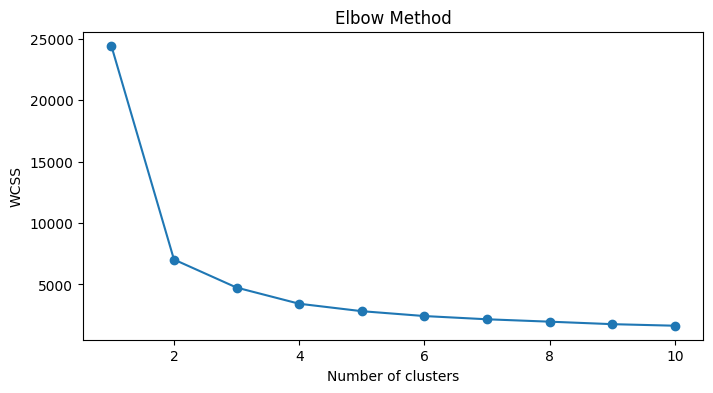

In [14]:
# Visualization: Stacked Plots for Speed, Flow, Occupancy
df_viz = df_agg.copy()
df_viz['day_type'] = df_viz['day_of_week'].apply(lambda x: 'Weekend' if x >= 5 else 'Weekday')

plot_data = df_viz.groupby(['hour', 'day_type'])[['speed', 'flow', 'occ']].mean().reset_index()
all_days = df_viz.groupby('hour')[['speed', 'flow', 'occ']].mean().reset_index()
all_days['day_type'] = 'All Days'
plot_data = pd.concat([plot_data, all_days])

# Speed Plot
plt.figure(figsize=(10, 5))
sns.lineplot(x='hour', y='speed', hue='day_type', data=plot_data, style='day_type', markers=True)
plt.title('Rata-rata Kecepatan per Jam')
plt.xticks(range(24))
plt.grid(True)
plt.show()

# Flow Plot
plt.figure(figsize=(10, 5))
sns.lineplot(x='hour', y='flow', hue='day_type', data=plot_data, style='day_type', markers=True)
plt.title('Rata-rata Flow per Jam')
plt.xticks(range(24))
plt.grid(True)
plt.show()

# Occupancy Plot
plt.figure(figsize=(10, 5))
sns.lineplot(x='hour', y='occ', hue='day_type', data=plot_data, style='day_type', markers=True)
plt.title('Rata-rata Occupancy per Jam')
plt.xticks(range(24))
plt.grid(True)
plt.show()

# Correlation Heatmap
plt.figure(figsize=(8, 6))
corr_cols = ['speed', 'flow', 'occ', 'hour', 'day_of_week', 'month']
sns.heatmap(df_agg[corr_cols].corr(), annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
plt.title('Correlation Heatmap')
plt.show()

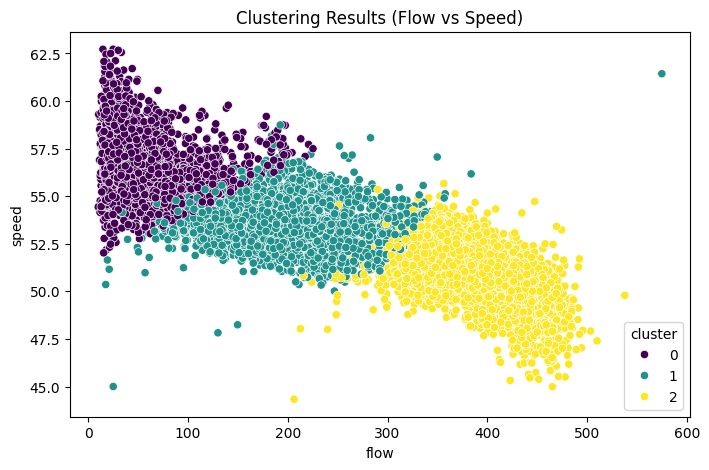

In [15]:
# Visualization: Stacked Plots for Speed, Flow, Occupancy
df_viz = df_agg.copy()
df_viz['day_type'] = df_viz['day_of_week'].apply(lambda x: 'Weekend' if x >= 5 else 'Weekday')

plot_data = df_viz.groupby(['hour', 'day_type'])[['speed', 'flow', 'occ']].mean().reset_index()
all_days = df_viz.groupby('hour')[['speed', 'flow', 'occ']].mean().reset_index()
all_days['day_type'] = 'All Days'
plot_data = pd.concat([plot_data, all_days])

# Speed Plot
plt.figure(figsize=(10, 5))
sns.lineplot(x='hour', y='speed', hue='day_type', data=plot_data, style='day_type', markers=True)
plt.title('Rata-rata Kecepatan per Jam')
plt.xticks(range(24))
plt.grid(True)
plt.show()

# Flow Plot
plt.figure(figsize=(10, 5))
sns.lineplot(x='hour', y='flow', hue='day_type', data=plot_data, style='day_type', markers=True)
plt.title('Rata-rata Flow per Jam')
plt.xticks(range(24))
plt.grid(True)
plt.show()

# Occupancy Plot
plt.figure(figsize=(10, 5))
sns.lineplot(x='hour', y='occ', hue='day_type', data=plot_data, style='day_type', markers=True)
plt.title('Rata-rata Occupancy per Jam')
plt.xticks(range(24))
plt.grid(True)
plt.show()

# Correlation Heatmap
plt.figure(figsize=(8, 6))
corr_cols = ['speed', 'flow', 'occ', 'hour', 'day_of_week', 'month']
sns.heatmap(df_agg[corr_cols].corr(), annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
plt.title('Correlation Heatmap')
plt.show()